In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
import time

In [2]:
class Model:

    def __init__(self, sess, name, learning_rate=0.001, period=120):
        self.sess = sess
        self.name = name
        self._build_net(period, learning_rate)
        

    def _build_net(self, period, learning_rate):
        with tf.variable_scope(self.name):
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, period, 4])

            # 120x4 (OHLC), Input Layer
            ohlc = tf.reshape(self.X, [-1, period,  4])
            # 3(down trend, neither, up trend), ouput layer
            self.Y = tf.placeholder(tf.float32, [None, 2])

            # Convolutional Layer #1
            conv1 = tf.layers.conv1d(inputs=ohlc, filters=32, kernel_size=5, padding="same", activation=tf.nn.relu)
            # Pooling Layer #1
            #pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=1, padding="same", strides=1)
            dropout1 = tf.layers.dropout(inputs=conv1, rate=0.7, training=self.training)

            # Convolutional Layer #2 and Pooling Layer #2
            conv2 = tf.layers.conv1d(inputs=dropout1, filters=64, kernel_size=5, padding="same", activation=tf.nn.relu)
            #pool2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=1, padding="same", strides=2)
            dropout2 = tf.layers.dropout(inputs=conv2, rate=0.7, training=self.training)

            # Convolutional Layer #3 and Pooling Layer #3
            conv3 = tf.layers.conv1d(inputs=dropout2, filters=128, kernel_size=5, padding="same", activation=tf.nn.relu)
            #pool3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=1, padding="same", strides=1)
            dropout3 = tf.layers.dropout(inputs=conv3, rate=0.7, training=self.training)

            # Dense Layer with Relu
            size = np.prod(dropout3.shape.as_list()[1:])
            flat = tf.reshape(dropout3, [-1, size])
            dense4 = tf.layers.dense(inputs=flat, units=1024, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 1024 inputs -> 3 outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=2)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})

### 1. 데이터 불러오기

In [49]:
xy = np.genfromtxt('data/120day_trend(normed_by_globalstd)_1.csv', delimiter=',', dtype=np.float32)

##### Data Reconstruction

In [59]:
test_len = 100
length = xy.shape[0]

X_Data = np.stack( (xy[0::4, :-1], xy[1::4, :-1], xy[2::4, :-1], xy[3::4, :-1]), axis=-1)
# y 데이터 구조 변경: 0~2 --> [1,0,0], [0,1,0], [0,0,1]
y = xy[::4, -1].astype(np.int16)

# trend result
uptrend = downtrend = np.zeros((y.size, 2))
uptrend[np.arange(y.size), np.where(y==2, 1, 0)] = 1
downtrend[np.arange(y.size), np.where(y==0, 1, 0)] = 1

#s = (y[y>0] = 1)
#Y_Data = np.zeros((y.size, 2))
#Y_Data[np.arange(y.size), y] = 1

#train data
X_Train = X_Data[test_len:]
Y_Train = Y_Data[test_len:]
X_Test = X_Data[:test_len]
Y_Test = Y_Data[:test_len]

In [61]:
# initialize
sess = tf.Session()

In [62]:
up_model = Model(sess, "uptrend")
down_model = Model(sess, "downtrend")

In [5]:
#saver = tf.train.Saver()
#s=saver.restore(sess, "tf/120day_trend_weight.ckpt")

INFO:tensorflow:Restoring parameters from tf/120day_trend_weight.ckpt


In [17]:
sess.run(tf.global_variables_initializer())

In [21]:
timer = time.time()
for step in range(300):
    c, _ = m1.train(X_Train, Y_Train)
    if step % 100 == 0:
        timediff = time.time() - timer
        timer = time.time()
        print('step: ', step, 'cost: ', c , ' (%.2f sec)'%timediff)
#save_path = saver.save(sess, "tf/120day_trend_weight.ckpt")
#print("Model saved in file: %s" % save_path)

step:  0 cost:  0.0383082  (2.69 sec)
step:  100 cost:  0.0352384  (319.44 sec)
step:  200 cost:  0.0132907  (322.91 sec)


NameError: name 'save_path' is not defined

In [22]:
print('Accuracy:', m1.get_accuracy(X_Test, Y_Test))

Accuracy: 0.93


### 2. 테스트

##### 1) 테스트 데이터

real:  1
pred: 1
[[  1.86053654e-07   9.99999762e-01   9.92644231e-11]]


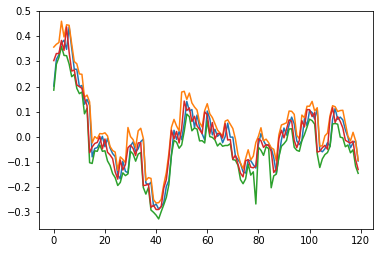

In [ ]:
for num in range(1):
    #num = np.random.randint(0,len(test_X))
    data = X_Test[num]
    real = np.argmax(Y_Test[num])
    pred = m1.predict([X_Test[num]])
    
    print('real: ', real)
    print('pred:', np.argmax(pred))
    print(pred)
    plt.plot(data)
    plt.show()
    input()
    clear_output(wait=True)

##### 2) 실 데이터

In [8]:
def westerncandlestick(ax, quotes, width=0.2, colorup='r', colordown='k', 
                 linewidth=0.5):

    OFFSET = width / 2.0

    lines = []
    openlines = []
    closelines = []
    for q in quotes:
        t, open, high, low, close = q[:5]

        if close >= open:
            color = colorup
        else:
            color = colordown

        vline = Line2D( xdata=(t, t), ydata=(low, high),
            color=color, linewidth=linewidth, antialiased=True)
        lines.append(vline)

        openline = Line2D(xdata=(t - OFFSET, t), ydata=(open,open),
                          color=color, linewidth=linewidth, antialiased=True)
        openlines.append(openline)

        closeline = Line2D(xdata=(t , t+OFFSET), ydata=(close,close),
                          color=color, linewidth=linewidth, antialiased=True)
        closelines.append(closeline)

        ax.add_line(vline)
        ax.add_line(openline)
        ax.add_line(closeline)
    
    ax.axhline(linewidth=1, color='g')
    ax.axvline(x=int(t/2), linewidth=1, color='g')
    ax.autoscale_view()

    return lines, openlines, closelines

In [9]:
#실 데이터 테스트
import quandl
import pandas as pd
from matplotlib.lines import Line2D
quandl.ApiConfig.api_key = "UzB-e5CDdoACq4ENxbVS"
window = 240
df = pd.read_csv('data/SCF-datasets-codes.csv')
codes_tmp = []
contents = []
for idx, code, content in df.itertuples():
    if code[-4:] == '1_OB':
        codes_tmp.append(code)
        contents.append(content)
codes = pd.DataFrame()
codes['code'] = codes_tmp
codes['contents'] = contents

CBOT Rough Rice Futures #1 (RR1) - Front Month - Backwards Panama Adjusted Prices, Roll on Open Interest Switc


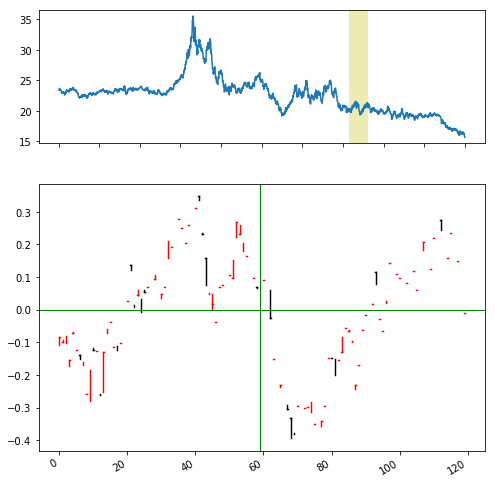

pred: 1
[[-25.13899994  15.85700035  -2.94400001]]
prob:  [[ 0.  1.  0.]]


In [ ]:
window = 120
while True:
    idx = np.random.randint(0, len(codes))
    code = codes.iloc[idx].code
    content = codes.iloc[idx].contents

    raw_data = quandl.get(code)
    raw_data.drop(['Volume', 'Prev. Day Open Interest'], axis=1, inplace=True)
    std = raw_data.Settle.std()
    length = len(raw_data)
    
    for i in range(10):
        print(content[:-30])
        
        #시작일자 랜덤 설정
        start = np.random.randint(0, length -  window)
        end = start + window

        #Data Normalization
        data = raw_data[start:end]
        data = (data-data.Settle.mean())/std
        data.insert(0, 'index', np.arange(len(data)))
        
        #그래프 
        fig, (ax) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 2]}, figsize=(8,9))
        fig.autofmt_xdate()
            
        ax[0].plot(raw_data.index.values, raw_data.Settle.values)
        ax[0].axvspan(raw_data.index.values[start], raw_data.index.values[end], facecolor='y', alpha=0.3)
        
        westerncandlestick(ax[1], data.values, linewidth=1.44)
        plt.show()
        
        #추세
        time.sleep(0.1)
        
        temp = data.drop('index', axis=1).values.T
        test_data = np.stack( (temp[0::4, :], temp[1::4, :], temp[2::4, :], temp[3::4, :]), axis=-1)
        pred = m1.predict(test_data)
    
        print('pred:', np.argmax(pred))
        print(np.round(pred,3))
        print('prob: ', np.round(sess.run(tf.nn.softmax(pred)),3))
        key = input()
        
        clear_output(wait=True)
        if key == 'q':
            break
    if key == 'q':
            break
    clear_output(wait=True)

In [39]:
sess.run(tf.nn.softmax(pred))

array([[  6.31562500e-08,   9.99999881e-01,   3.38847349e-21]], dtype=float32)